In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from pandas import DataFrame
from datetime import datetime
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D ,AveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a\AppData\Roaming\Python\Python37\site-packages\tensorf

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6377373837733936642
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 8267812044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15650974068088029753
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
workdir = "E://Ronny_TF//201120_EDC_EYDC_MDC_other_PC//Dataset_EDC_EYDC_MDC_regen"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]
# IC50evaluation//Dataset//Scenario2_EDC-11K_minmax

dataset = np.load(workdir + "//EDC11K_dataset.npz") # input file
ss0 = np.load(workdir + '//EDC11K_datase_r0_9_1.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

0 42


In [8]:
x.shape

(11360, 21313)

In [9]:
training_image_array.shape

(10224, 21313)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10224, 21313, 1) (10224,) (1136, 21313, 1) (1136,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (10224, 21313, 1)
10224 train samples
1136 test samples


In [15]:
training_image_array.shape

(10224, 21313)

In [16]:
# In[10]:
with K.tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 21313, 1)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10657, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 2131, 16)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1

In [17]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with K.tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2020-11-23 15:46:16.892711
Instructions for updating:
Use tf.cast instead.
Train on 10224 samples, validate on 1136 samples
Epoch 1/150
10224/10224 [==============================] - 24s 2ms/step - loss: 3.2573 - mean_squared_error: 3.2573 - mean_absolute_error: 1.4905 - val_loss: 4.3637 - val_mean_squared_error: 4.3637 - val_mean_absolute_error: 1.4132
Epoch 2/150
10224/10224 [==============================] - 13s 1ms/step - loss: 1.3557 - mean_squared_error: 1.3557 - mean_absolute_error: 0.8411 - val_loss: 2.0123 - val_mean_squared_error: 2.0123 - val_mean_absolute_error: 1.0085
Epoch 3/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.9942 - mean_squared_error: 0.9942 - mean_absolute_error: 0.6893 - val_loss: 1.3377 - val_mean_squared_error: 1.3377 - val_mean_absolute_error: 0.7977
Epoch 4/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.8380 - mean_squared_error: 0.8380 - mean_absolute_error: 0.6318 - val_loss: 1.1239 - v

Epoch 35/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1508 - mean_squared_error: 0.1508 - mean_absolute_error: 0.2815 - val_loss: 0.7925 - val_mean_squared_error: 0.7925 - val_mean_absolute_error: 0.4657
Epoch 36/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1431 - mean_squared_error: 0.1431 - mean_absolute_error: 0.2682 - val_loss: 0.8000 - val_mean_squared_error: 0.8000 - val_mean_absolute_error: 0.4537
Epoch 37/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1356 - mean_squared_error: 0.1356 - mean_absolute_error: 0.2599 - val_loss: 0.7710 - val_mean_squared_error: 0.7710 - val_mean_absolute_error: 0.4544
Epoch 38/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1464 - mean_squared_error: 0.1464 - mean_absolute_error: 0.2686 - val_loss: 0.8117 - val_mean_squared_error: 0.8117 - val_mean_absolute_error: 0.4494
Epoch 39/150
10224/10224 [==============================] - 13s 1ms/

10224/10224 [==============================] - 13s 1ms/step - loss: 0.0945 - mean_squared_error: 0.0945 - mean_absolute_error: 0.2131 - val_loss: 0.7648 - val_mean_squared_error: 0.7648 - val_mean_absolute_error: 0.4398
Epoch 71/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.0890 - mean_squared_error: 0.0890 - mean_absolute_error: 0.2107 - val_loss: 0.7588 - val_mean_squared_error: 0.7588 - val_mean_absolute_error: 0.4370
Epoch 72/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.0894 - mean_squared_error: 0.0894 - mean_absolute_error: 0.2136 - val_loss: 0.7894 - val_mean_squared_error: 0.7894 - val_mean_absolute_error: 0.4491
Epoch 73/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1286 - mean_squared_error: 0.1286 - mean_absolute_error: 0.2357 - val_loss: 0.8089 - val_mean_squared_error: 0.8089 - val_mean_absolute_error: 0.4712
Epoch 74/150
10224/10224 [==============================] - 13s 1ms/step - loss: 

10224/10224 [==============================] - 13s 1ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - mean_absolute_error: 0.2209 - val_loss: 0.8817 - val_mean_squared_error: 0.8817 - val_mean_absolute_error: 0.4803
Epoch 106/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1195 - mean_squared_error: 0.1195 - mean_absolute_error: 0.2144 - val_loss: 0.9085 - val_mean_squared_error: 0.9085 - val_mean_absolute_error: 0.4804
Epoch 107/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1421 - mean_squared_error: 0.1421 - mean_absolute_error: 0.2295 - val_loss: 0.8936 - val_mean_squared_error: 0.8936 - val_mean_absolute_error: 0.4880
Epoch 108/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.1866 - mean_squared_error: 0.1866 - mean_absolute_error: 0.2591 - val_loss: 0.9544 - val_mean_squared_error: 0.9544 - val_mean_absolute_error: 0.4853
Epoch 109/150
10224/10224 [==============================] - 13s 1ms/step - lo

10224/10224 [==============================] - 13s 1ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - mean_absolute_error: 0.1474 - val_loss: 0.8154 - val_mean_squared_error: 0.8154 - val_mean_absolute_error: 0.4334
Epoch 141/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1506 - val_loss: 0.7907 - val_mean_squared_error: 0.7907 - val_mean_absolute_error: 0.4328
Epoch 142/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1463 - val_loss: 0.8146 - val_mean_squared_error: 0.8146 - val_mean_absolute_error: 0.4322
Epoch 143/150
10224/10224 [==============================] - 13s 1ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1448 - val_loss: 0.8242 - val_mean_squared_error: 0.8242 - val_mean_absolute_error: 0.4358
Epoch 144/150
10224/10224 [==============================] - 13s 1ms/step - lo

In [18]:
import json
from keras.models import model_from_json, load_model
workdir = "E://Ronny_TF//201120_EDC_EYDC_MDC_other_PC//Result//EDC11K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//EDC11K_ResNet_model_fix_v3.h5')
with open(workdir + '//EDC11K_ResNet_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [19]:
# Option 2: Save/Load the Entire Model
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//EDC11K_ResNet_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [20]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

1136/1136 [==============================] - 1s 550us/step


In [21]:
test_eval

[0.7912855177698, 0.7912855177698, 0.4330675652329351]

In [22]:
accuracy = model_train.history['mean_squared_error']
val_accuracy = model_train.history['val_mean_squared_error']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [23]:
import matplotlib
from matplotlib import pyplot as plt

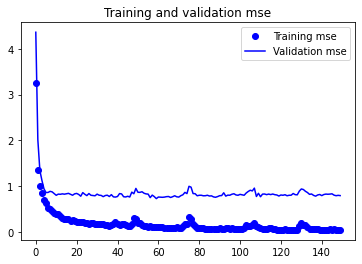

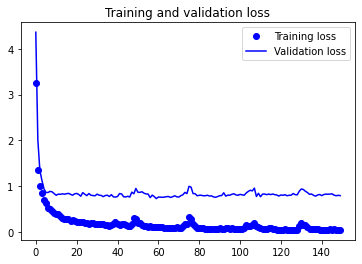

In [24]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes = model.predict(test_X)

In [26]:
predicted_value = predicted_classes

In [27]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [28]:
c.to_csv(workdir + '//EDC11K_ResNet_pred_obs_table.csv')

In [29]:
c

,Predicted,Test
0,-0.324614,0.194956
1,-0.212160,-0.678423
2,2.079772,2.079442
3,1.868133,2.079442
4,1.665277,1.269606
...,...,...
1131,2.093735,2.079442
1132,2.076246,2.079442
1133,2.076531,2.079442
1134,1.364141,0.178212


In [30]:
predicted_value.shape

(1136, 1)

In [31]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.8354425452723175, intercept=0.235131180501835, rvalue=0.8914504308670708, pvalue=0.0, stderr=0.012610270299565404)

In [32]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.7905884646382674


In [33]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.8895422988253624


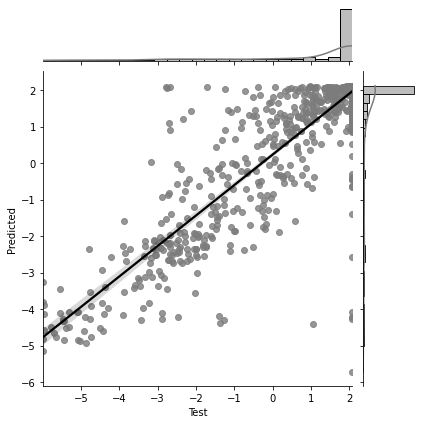

In [34]:
workdir = "E://Ronny_TF//201120_EDC_EYDC_MDC_other_PC//Result//Fig_backbone//EDC11K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//EDC11K_ResNet.png', dpi=300)